In [1]:
%load_ext autoreload

In [2]:
import sys
from timeit import default_timer as timer
import h5py
import numpy as np
import matplotlib.pyplot as plt

import keras

from evaluator import visualization as vis
from evaluator import defense
from evaluator.models.resnet import Resnet
from evaluator.models.model import CarliniCifarWrapper, RobustModel
from evaluator.dataset import CIFAR
from evaluator.utils import merge_and_generate_labels

%autoreload 2

/home/jungj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/jungj/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/jungj/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/jungj/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will b

## Setup model and load weights

In [3]:
data = CIFAR()
resnet = Resnet(data,bayesian=True)
model = resnet.model

In [4]:
path = "forks/nn_breaking_detection/models/cifar"
model.load_weights(path)

## Load some real and adversarial examples and plot them

(10000, 32, 32, 3)


(-0.5, 319.5, 31.5, -0.5)

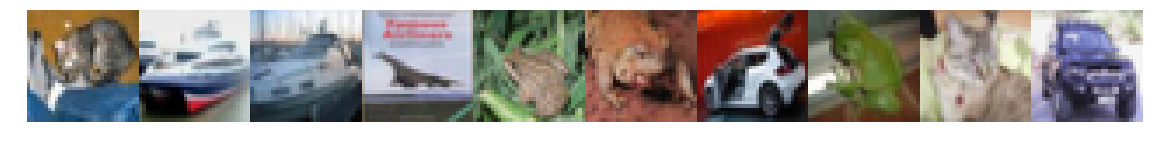

In [5]:
real = np.array(h5py.File('forks/nn_breaking_detection/adv_ex_10000.h5','r')['real'])
print(real.shape)
real_scaled = real - real.min()
plt.figure(figsize=(20,20))
plt.imshow(np.concatenate([real_scaled[i] for i in range(10)], axis=1))
plt.axis('off')

(10000, 32, 32, 3)


(-0.5, 319.5, 31.5, -0.5)

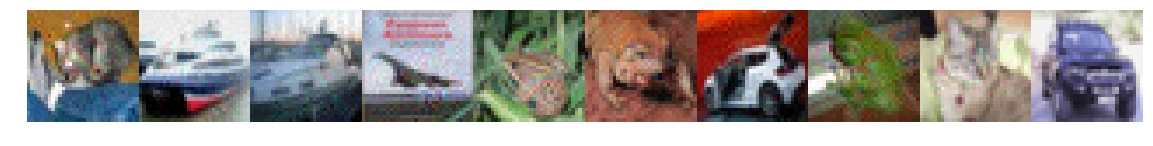

In [6]:
adv_johannes = np.array(h5py.File('forks/nn_breaking_detection/adv_ex_10000.h5','r')['adv'])
print(adv_johannes.shape)
adv_johannes_scaled = adv_johannes - adv_johannes.min()
plt.figure(figsize=(20,20))
plt.imshow(np.concatenate([adv_johannes_scaled[i] for i in range(10)], axis=1))
plt.axis('off')

In [7]:
sess = keras.backend.get_session()

In [75]:
Lid2 = defense.LID(model,sess, real[:100], adv_johannes[:100], k= 20, batch_size = 100)
#% time lids_normal2, lids_adv2 = Lid2.lid_scores()

In [76]:
# lids_adv = lids_adv2
# lids_normal = lids_normal2

In [77]:
import cProfile, pstats, io



def profile(fnc):
    
    """A decorator that uses cProfile to profile a function"""
    
    def inner(*args, **kwargs):
        
        pr = cProfile.Profile()
        pr.enable()
        retval = fnc(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return retval

    return inner

In [78]:
@profile
def lid_scores_profile(layers=None):
    return Lid2.lid_scores(layers=layers)

In [61]:
lids, lids_adv = lid_scores_profile()

Number of layers to estimate:  115
Batch #%d 1
         509978 function calls (509258 primitive calls) in 12.704 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.704   12.704 <ipython-input-35-3ae3566e5c01>:1(lid_scores_profile)
        1    0.000    0.000   12.704   12.704 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:118(lid_scores)
        1    0.001    0.001   12.704   12.704 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:149(get_lids_random_batch)
        1    0.003    0.003   12.696   12.696 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:173(estimate)
      230    0.004    0.000   11.831    0.051 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:134(mle_batch)
      230    0.007    0.000   11.344    0.049 /home/jungj/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:2060(cdist)
      230   10.717    0.047   10.717    0.04

In [62]:
lids_slow, lids_adv_slow = lid_scores_profile()

Number of layers to estimate:  116
Batch #%d 1
         725836 function calls (721660 primitive calls) in 42.059 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   42.059   42.059 <ipython-input-35-3ae3566e5c01>:1(lid_scores_profile)
        1    0.000    0.000   42.059   42.059 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:118(lid_scores)
        1    0.000    0.000   42.059   42.059 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:149(get_lids_random_batch)
        1    0.009    0.009   41.990   41.990 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:205(estimate)
      232    0.006    0.000   27.767    0.120 /home/jungj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2468(__call__)
      232    0.003    0.000   27.676    0.119 /home/jungj/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:790(run)
      232  

In [82]:
lid_scores_profile(layers=[-1])

Number of layers to estimate:  1
Batch #%d 1
         6380 function calls (6344 primitive calls) in 0.721 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.721    0.721 <ipython-input-78-3ae3566e5c01>:1(lid_scores_profile)
        1    0.000    0.000    0.721    0.721 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:119(lid_scores)
        1    0.000    0.000    0.721    0.721 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:150(get_lids_random_batch)
        1    0.000    0.000    0.718    0.718 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:168(estimate)
        2    0.000    0.000    0.707    0.353 /home/jungj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2468(__call__)
        2    0.000    0.000    0.704    0.352 /home/jungj/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:790(run)
        2    0.000

(array([[ 4.5172205],
        [ 2.299685 ],
        [ 3.0015132],
        [ 6.5424576],
        [ 2.9266965],
        [ 2.0914419],
        [ 7.6928926],
        [ 3.2757769],
        [ 3.7846644],
        [ 3.3002803],
        [ 4.938877 ],
        [ 2.0313854],
        [ 3.9070327],
        [ 3.0279703],
        [ 2.0297375],
        [ 4.970346 ],
        [ 5.9149413],
        [ 2.9406774],
        [ 1.9117216],
        [ 2.1923862],
        [ 3.7506719],
        [ 3.4588473],
        [ 9.417688 ],
        [ 2.511292 ],
        [ 3.5728986],
        [ 7.259241 ],
        [ 5.966716 ],
        [ 3.3511138],
        [ 2.037021 ],
        [ 2.3258152],
        [ 3.002321 ],
        [ 3.5473328],
        [ 8.748158 ],
        [ 9.291382 ],
        [ 2.1740801],
        [ 4.6986456],
        [ 4.8261685],
        [ 4.080426 ],
        [ 3.8549342],
        [ 7.048598 ],
        [10.20424  ],
        [ 2.0780785],
        [ 4.091225 ],
        [ 1.9948945],
        [ 4.0959125],
        [ 

In [88]:
Lid = defense.LID(model,sess, real[:1000], adv_johannes[:1000], k= 20, batch_size = 1000)
@profile
def lid_scores_profile(layers=None):
    return Lid.lid_scores(layers=layers)

In [89]:
lids_real, lids_adv = lid_scores_profile()

Number of layers to estimate:  115
Batch  1
         4649980 function calls (4649260 primitive calls) in 1461.076 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000 1461.076 1461.076 <ipython-input-88-de8d4925b8d7>:2(lid_scores_profile)
        1    0.000    0.000 1461.076 1461.076 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:119(lid_scores)
        1    0.002    0.002 1461.076 1461.076 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:150(get_lids_random_batch)
        1    0.052    0.052 1461.066 1461.066 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:168(estimate)
      230    1.186    0.005 1452.444    6.315 /home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:136(mle_batch)
      230    0.324    0.001 1436.174    6.244 /home/jungj/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:2060(cdist)
      230 1412.091    6.140 1412.091    6.1